In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from math import ceil
from datetime import datetime, timedelta

In [309]:
df = pd.read_csv('dataset_mood_smartphone.csv')

In [310]:
"""
Check stats on NaN values and Remove NaN values
"""
# df with NaN values
df_na = df[pd.isna(df['value'])]

# Counts NaN values for each variable
df_na_variables = df_na['variable'].value_counts()
df = df.dropna()

In [311]:
"""
Delete negative time measurements
"""

'\nDelete negative time measurements\n'

In [312]:
df['time'] = pd.to_datetime(df['time'])
df['date'] = df['time'].dt.date
df['hour'] = df['time'].dt.hour
unique_variables = df['variable'].unique()
participants = df['id'].unique()
days = df['date'].unique()

In [313]:
"""
Detecting outliers with IQR
"""

# Function to detect outliers within a group
def detect_outliers(group):
    Q1 = group['value'].quantile(0.25)
    Q3 = group['value'].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Return only outliers within the group
    return group[(group['value'] < lower_bound) | (group['value'] > upper_bound)]

# Group by participant and apply the outlier detection
outliers_by_variable_df = df.groupby('variable').apply(detect_outliers).reset_index(drop=True)

# print("Outliers detected within each variable:")
# print(outliers_by_variable_df)

outliers_count_per_variable = outliers_by_variable_df.groupby('variable')['value'].count().reset_index(name='count')
print(outliers_count_per_variable)


                variable  count
0               activity   2223
1         appCat.builtin  10152
2   appCat.communication   6401
3   appCat.entertainment   4517
4         appCat.finance    118
5            appCat.game     85
6          appCat.office    848
7           appCat.other   1000
8          appCat.social   1838
9          appCat.travel    181
10        appCat.unknown     80
11      appCat.utilities    182
12        appCat.weather     10
13    circumplex.valence     31
14                  mood    400
15                screen  10055


In [314]:
active_subjects_hour = df.groupby(['hour'])['id'].unique().reset_index()

In [315]:
"""
Average data for each day:
"""
# non_time_variables = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity']
non_time_variables = ['mood', 'circumplex.arousal', 'circumplex.valence']
df_time = df[~df['variable'].isin(non_time_variables)]

# For time variables, we take the mean of each day averaged over the active participants of the corresponding day
daily_avg_df_time = df_time.groupby(['date', 'variable'])['value'].sum().reset_index()
daily_avg_df_time['value'] = daily_avg_df_time['value'] / len(active_subjects_day['date'])

# For non-time variables, we take the mean of all the inputs for each hour
df_non_time = df[df['variable'].isin(non_time_variables)]
daily_avg_df_non_time = df_non_time.groupby(['date', 'variable'])['value'].mean().reset_index()

# Merges the two dataframes
daily_avg_df = pd.concat([daily_avg_df_non_time, daily_avg_df_time], ignore_index=True)

In [316]:
"""
Stats on data
"""
print(f'Amount of measured variables: {len(unique_variables)}')
print(f'Amount of participants: {len(participants)}')
print(f'Experiment took place over {len(days)} days')
for variable in unique_variables:
    print(len(daily_avg_df['variable'] == variable))
print(daily_avg_df[daily_avg_df['variable'] == 'mood'])

##

Amount of measured variables: 19
Amount of participants: 27
Experiment took place over 113 days
1539
1539
1539
1539
1539
1539
1539
1539
1539
1539
1539
1539
1539
1539
1539
1539
1539
1539
1539
           date variable     value
2    2014-02-26     mood  6.250000
5    2014-02-27     mood  6.333333
8    2014-03-04     mood  7.000000
11   2014-03-05     mood  7.166667
14   2014-03-06     mood  7.222222
..          ...      ...       ...
281  2014-06-04     mood  7.000000
284  2014-06-05     mood  7.000000
287  2014-06-06     mood  7.500000
289  2014-06-07     mood  8.000000
292  2014-06-08     mood  6.500000

[98 rows x 3 columns]


Text(0.5, 1.0, 'Correlation Heatmap of Variables')

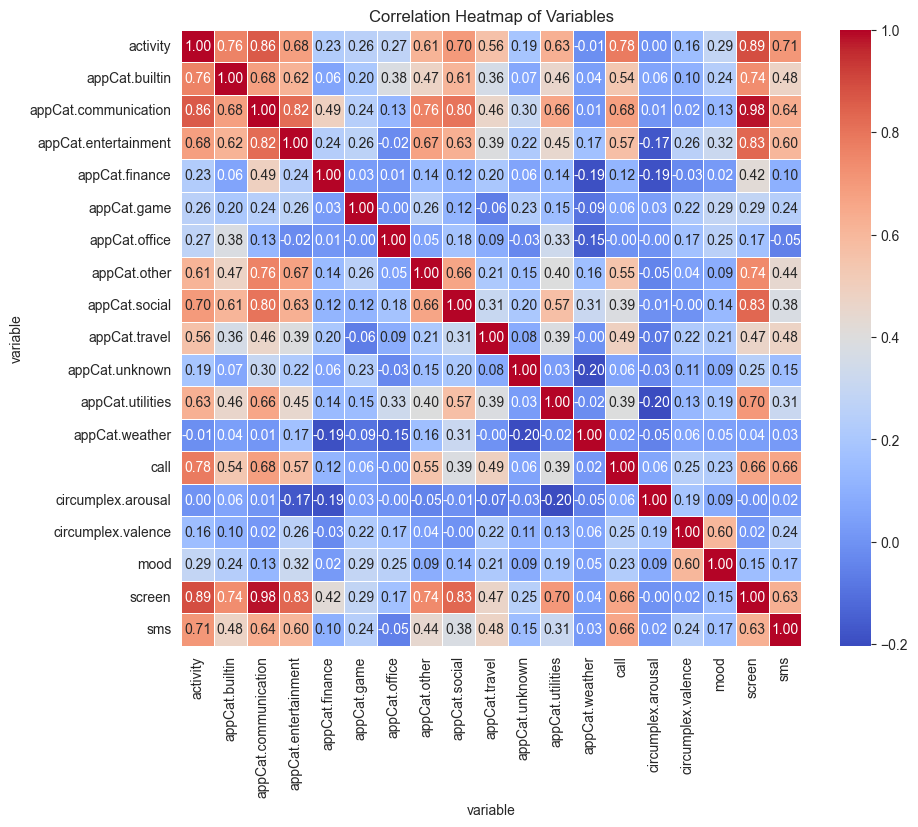

In [317]:
"""
Corr. heatmap, index on date
"""
df_pivoted = daily_avg_df.pivot_table(index='date', columns='variable', values='value')
corr_matrix = df_pivoted.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Variables')

In [318]:
"""
Average data for each hour
"""
non_time_variables = ['mood', 'circumplex.arousal', 'circumplex.valence', 'activity']
df_time = df[~df['variable'].isin(non_time_variables)]

# For time variables, we take the mean of each hour averaged over the active participants of the corresponding hour
hourly_avg_df_time = df_time.groupby(['hour', 'variable'])['value'].sum().reset_index()
hourly_avg_df_time['value'] = hourly_avg_df_time['value'] / len(active_subjects_hour['hour'])

# For non-time variables, we take the mean of all the inputs of each day
df_non_time = df[df['variable'].isin(non_time_variables)]
hourly_avg_df_non_time = df_non_time.groupby(['hour', 'variable'])['value'].mean().reset_index()

# Merges the two dataframes
hourly_avg_df = pd.concat([hourly_avg_df_non_time, hourly_avg_df_time], ignore_index=True)

Text(0.5, 1.0, 'Correlation Heatmap of Variables')

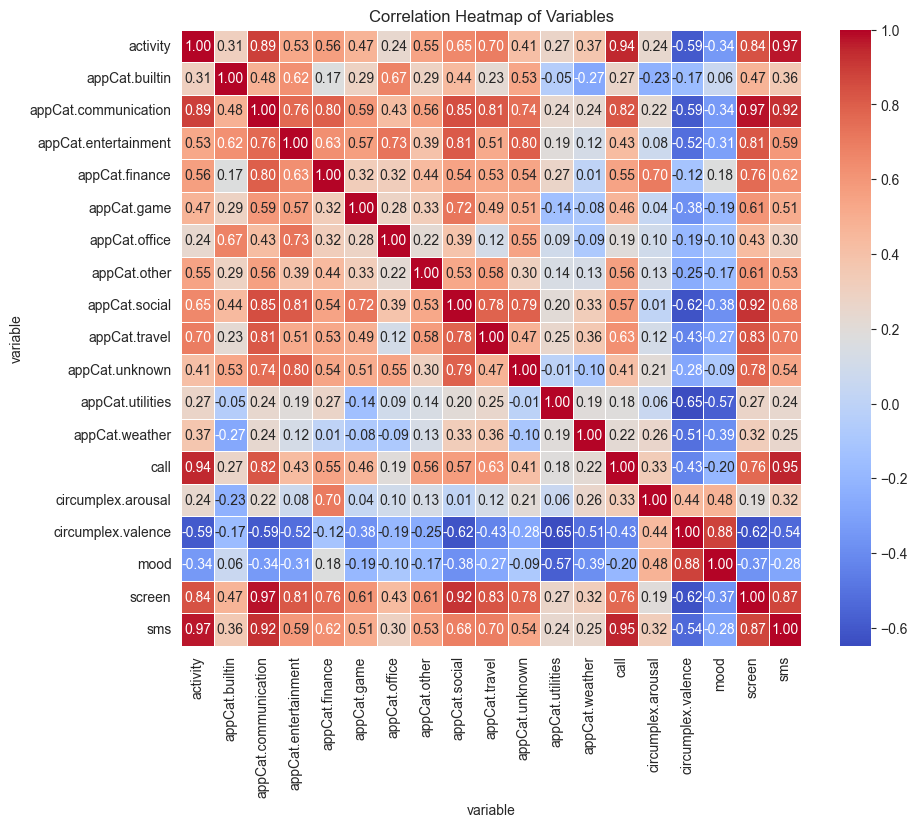

In [319]:
"""
Corr. heatmap, index on hour
"""
df_pivoted = hourly_avg_df.pivot_table(index='hour', columns='variable', values='value')
corr_matrix = df_pivoted.corr()

# Generate a heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Correlation Heatmap of Variables')

In [320]:
"""
Calculate end and start date of data collection on each variable
Conclusion: There are only 49 days of which between the latest starting date and the earliest stop date of measuring the predictors.
"""
start_dates = []
end_dates = []

for variable in unique_variables:
    var_df = df.loc[df['variable'] == variable]
    start_date = var_df['date'].min()
    start_dates.append(start_date)
    end_date = var_df['date'].max()
    end_dates.append(end_date)
    print(f'var: {variable}, start: {start_date}, end: {end_date}')

max_start_date = max(start_dates)
min_end_date = min(end_dates)

print('')
print(f'Latest start date: {max_start_date}, earliest end date: {min_end_date}')

var: mood, start: 2014-02-26, end: 2014-06-08
var: circumplex.arousal, start: 2014-02-26, end: 2014-06-08
var: circumplex.valence, start: 2014-02-26, end: 2014-06-08
var: activity, start: 2014-03-17, end: 2014-06-09
var: screen, start: 2014-03-13, end: 2014-06-08
var: call, start: 2014-02-17, end: 2014-06-06
var: sms, start: 2014-02-17, end: 2014-06-07
var: appCat.builtin, start: 2014-03-13, end: 2014-06-08
var: appCat.communication, start: 2014-03-13, end: 2014-06-08
var: appCat.entertainment, start: 2014-03-13, end: 2014-06-02
var: appCat.finance, start: 2014-03-15, end: 2014-05-09
var: appCat.game, start: 2014-03-20, end: 2014-05-13
var: appCat.office, start: 2014-03-15, end: 2014-05-28
var: appCat.other, start: 2014-03-13, end: 2014-06-08
var: appCat.social, start: 2014-03-13, end: 2014-06-08
var: appCat.travel, start: 2014-03-14, end: 2014-06-05
var: appCat.unknown, start: 2014-03-14, end: 2014-05-30
var: appCat.utilities, start: 2014-03-13, end: 2014-06-06
var: appCat.weather, st

In [321]:
# for variable in unique_variables:
#     print(len(hourly_avg_df['variable'] == variable))
# print(daily_avg_df[hourly_avg_df['variable'] == 'mood'])

ID: AS14.01, Start: 2014-02-26, End: 2014-05-04, Timeframe: 67 days, 0:00:00 
 Missing Dates: 21
Missing mood measurement dates for participant AS14.01: [datetime.date(2014, 2, 28), datetime.date(2014, 3, 1), datetime.date(2014, 3, 2), datetime.date(2014, 3, 3), datetime.date(2014, 3, 4), datetime.date(2014, 3, 5), datetime.date(2014, 3, 6), datetime.date(2014, 3, 7), datetime.date(2014, 3, 8), datetime.date(2014, 3, 9), datetime.date(2014, 3, 10), datetime.date(2014, 3, 11), datetime.date(2014, 3, 12), datetime.date(2014, 3, 13), datetime.date(2014, 3, 14), datetime.date(2014, 3, 15), datetime.date(2014, 3, 16), datetime.date(2014, 3, 17), datetime.date(2014, 3, 18), datetime.date(2014, 3, 19), datetime.date(2014, 3, 20)]


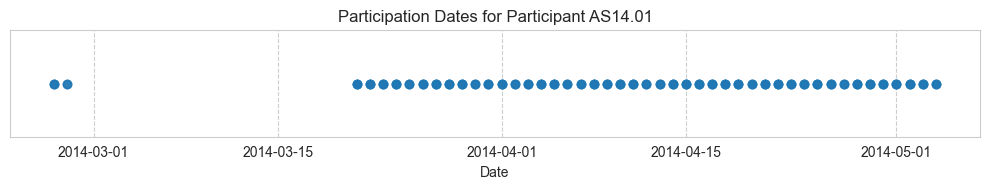

ID: AS14.02, Start: 2014-03-16, End: 2014-04-25, Timeframe: 40 days, 0:00:00 
 Missing Dates: 0
All dates between start and end have at least one mood measurement for participant AS14.02.


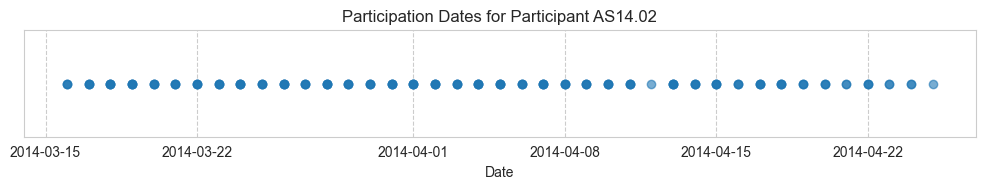

ID: AS14.03, Start: 2014-03-21, End: 2014-05-07, Timeframe: 47 days, 0:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.03: [datetime.date(2014, 5, 6)]


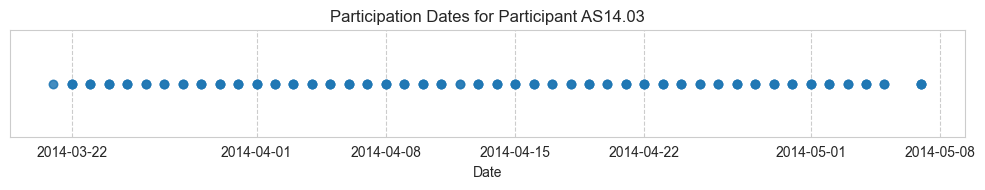

ID: AS14.05, Start: 2014-03-14, End: 2014-05-05, Timeframe: 52 days, 0:00:00 
 Missing Dates: 0
All dates between start and end have at least one mood measurement for participant AS14.05.


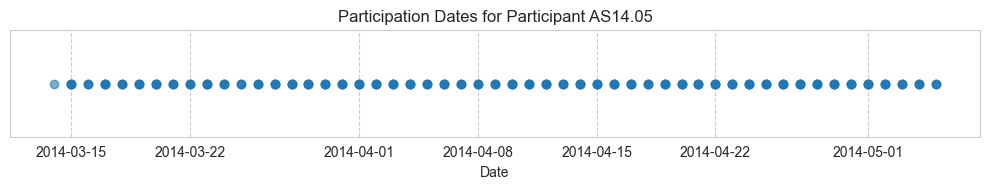

ID: AS14.06, Start: 2014-03-24, End: 2014-05-08, Timeframe: 45 days, 0:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.06: [datetime.date(2014, 5, 6)]


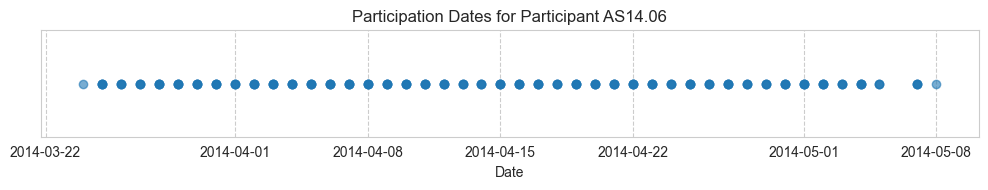

ID: AS14.07, Start: 2014-03-19, End: 2014-05-05, Timeframe: 47 days, 0:00:00 
 Missing Dates: 0
All dates between start and end have at least one mood measurement for participant AS14.07.


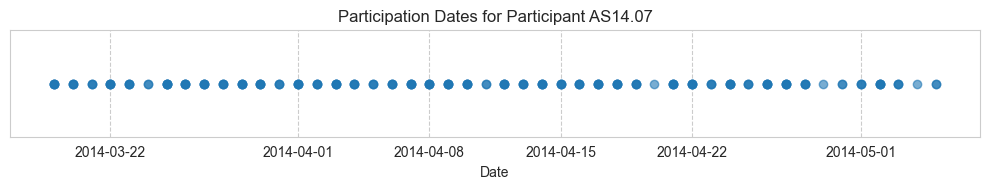

ID: AS14.08, Start: 2014-03-05, End: 2014-05-05, Timeframe: 61 days, 0:00:00 
 Missing Dates: 0
All dates between start and end have at least one mood measurement for participant AS14.08.


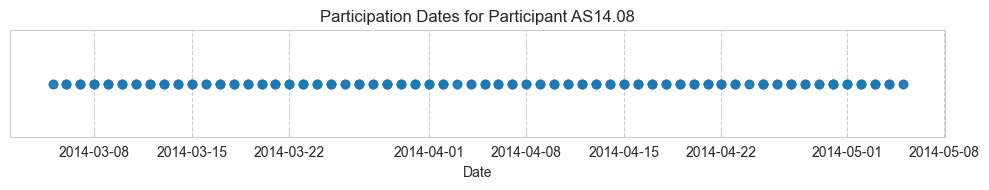

ID: AS14.09, Start: 2014-03-21, End: 2014-05-05, Timeframe: 45 days, 0:00:00 
 Missing Dates: 0
All dates between start and end have at least one mood measurement for participant AS14.09.


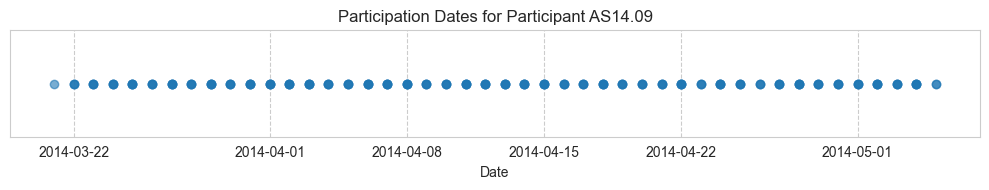

ID: AS14.12, Start: 2014-03-15, End: 2014-05-05, Timeframe: 51 days, 0:00:00 
 Missing Dates: 11
Missing mood measurement dates for participant AS14.12: [datetime.date(2014, 3, 16), datetime.date(2014, 3, 17), datetime.date(2014, 3, 18), datetime.date(2014, 3, 19), datetime.date(2014, 3, 20), datetime.date(2014, 3, 21), datetime.date(2014, 3, 22), datetime.date(2014, 3, 23), datetime.date(2014, 3, 24), datetime.date(2014, 3, 25), datetime.date(2014, 3, 26)]


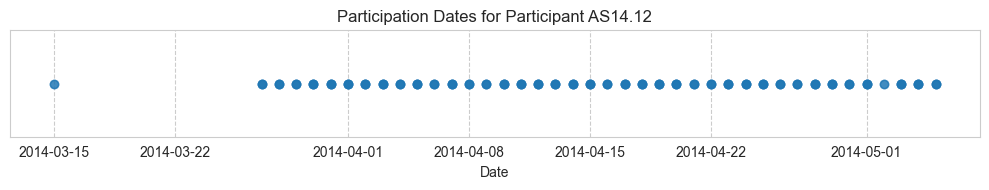

ID: AS14.13, Start: 2014-03-13, End: 2014-05-04, Timeframe: 52 days, 0:00:00 
 Missing Dates: 0
All dates between start and end have at least one mood measurement for participant AS14.13.


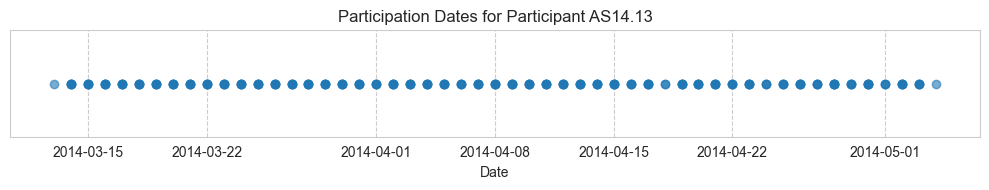

ID: AS14.14, Start: 2014-03-20, End: 2014-05-05, Timeframe: 46 days, 0:00:00 
 Missing Dates: 3
Missing mood measurement dates for participant AS14.14: [datetime.date(2014, 4, 13), datetime.date(2014, 4, 28), datetime.date(2014, 4, 29)]


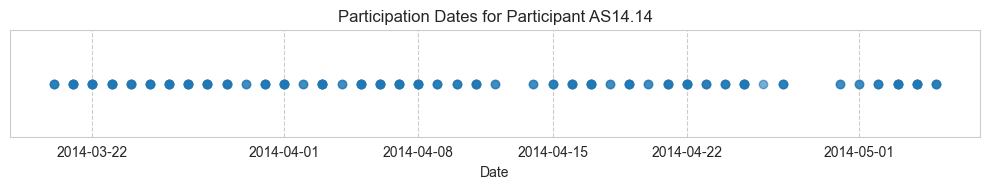

ID: AS14.15, Start: 2014-03-14, End: 2014-05-08, Timeframe: 55 days, 0:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.15: [datetime.date(2014, 5, 6)]


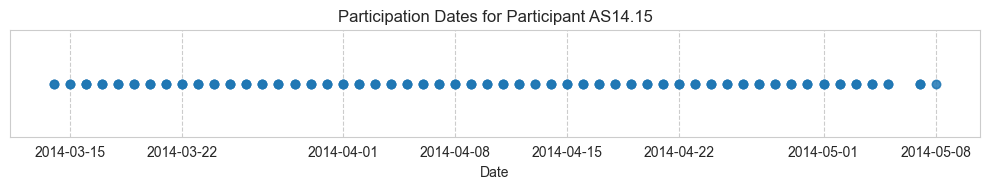

ID: AS14.16, Start: 2014-03-13, End: 2014-05-05, Timeframe: 53 days, 0:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.16: [datetime.date(2014, 5, 3)]


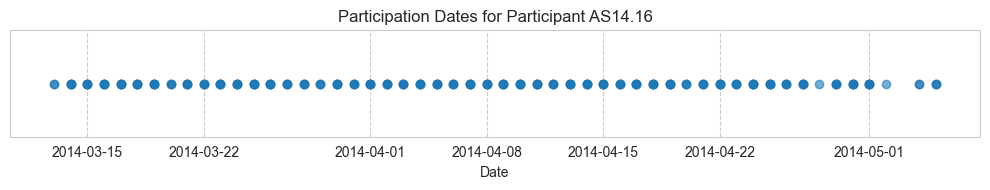

ID: AS14.17, Start: 2014-03-04, End: 2014-05-05, Timeframe: 62 days, 0:00:00 
 Missing Dates: 7
Missing mood measurement dates for participant AS14.17: [datetime.date(2014, 3, 15), datetime.date(2014, 3, 16), datetime.date(2014, 3, 17), datetime.date(2014, 3, 18), datetime.date(2014, 3, 19), datetime.date(2014, 3, 20), datetime.date(2014, 5, 4)]


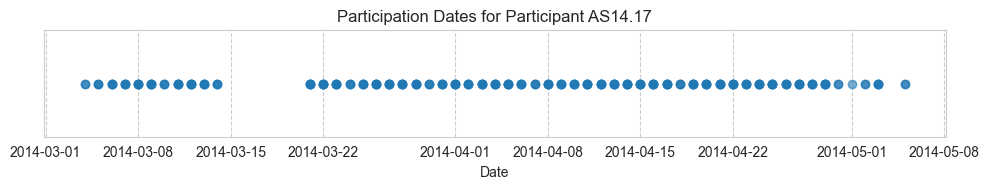

ID: AS14.19, Start: 2014-03-21, End: 2014-05-05, Timeframe: 45 days, 0:00:00 
 Missing Dates: 0
All dates between start and end have at least one mood measurement for participant AS14.19.


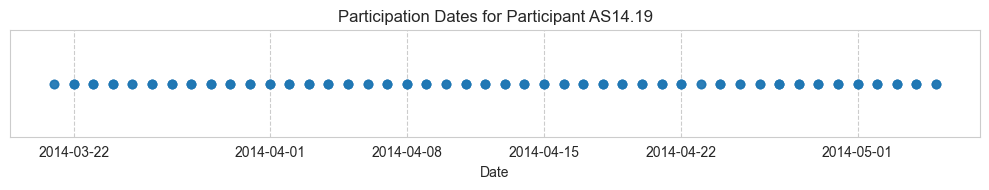

ID: AS14.20, Start: 2014-03-20, End: 2014-05-05, Timeframe: 46 days, 0:00:00 
 Missing Dates: 0
All dates between start and end have at least one mood measurement for participant AS14.20.


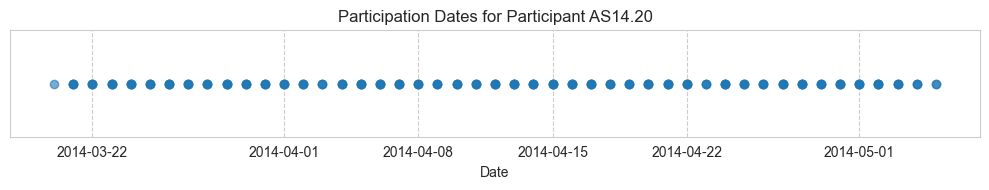

ID: AS14.23, Start: 2014-03-22, End: 2014-04-30, Timeframe: 39 days, 0:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.23: [datetime.date(2014, 4, 14)]


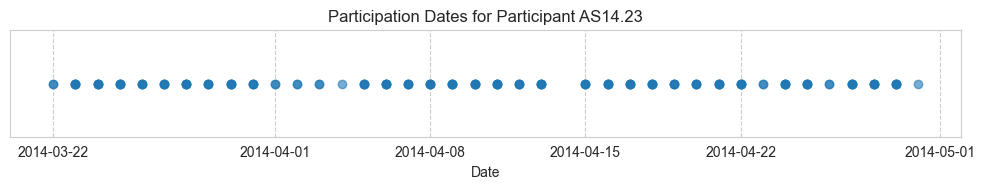

ID: AS14.24, Start: 2014-04-14, End: 2014-06-08, Timeframe: 55 days, 0:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.24: [datetime.date(2014, 5, 6)]


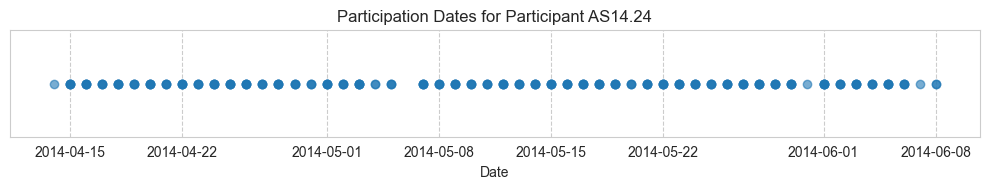

ID: AS14.25, Start: 2014-04-08, End: 2014-05-08, Timeframe: 30 days, 0:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.25: [datetime.date(2014, 5, 6)]


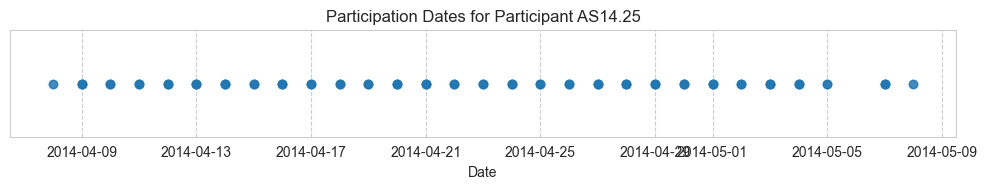

ID: AS14.26, Start: 2014-03-23, End: 2014-05-30, Timeframe: 68 days, 0:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.26: [datetime.date(2014, 5, 6)]


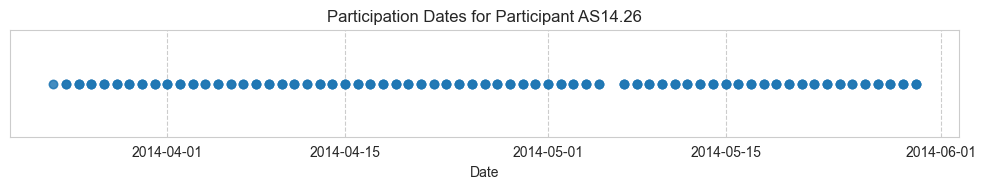

ID: AS14.27, Start: 2014-04-03, End: 2014-05-15, Timeframe: 42 days, 0:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.27: [datetime.date(2014, 5, 6)]


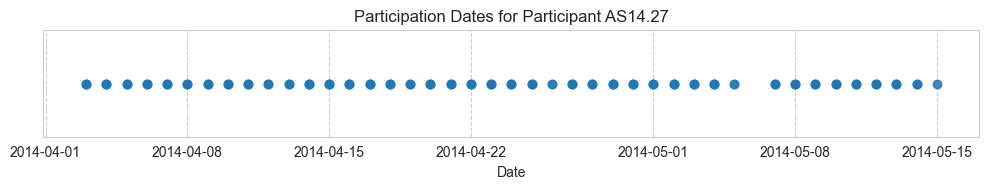

ID: AS14.28, Start: 2014-03-31, End: 2014-05-08, Timeframe: 38 days, 0:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.28: [datetime.date(2014, 5, 6)]


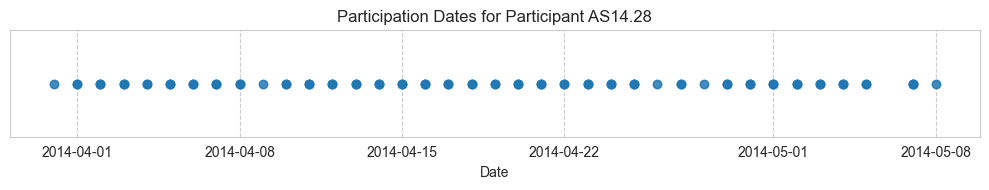

ID: AS14.29, Start: 2014-04-02, End: 2014-05-15, Timeframe: 43 days, 0:00:00 
 Missing Dates: 2
Missing mood measurement dates for participant AS14.29: [datetime.date(2014, 5, 2), datetime.date(2014, 5, 6)]


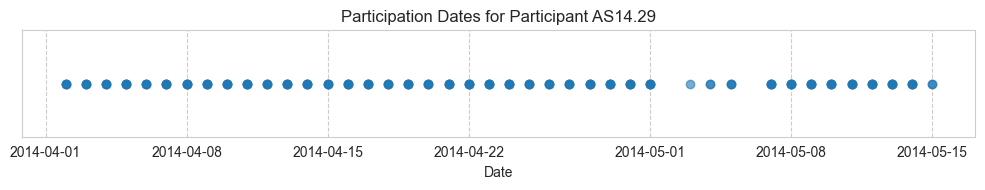

ID: AS14.30, Start: 2014-03-20, End: 2014-05-05, Timeframe: 46 days, 0:00:00 
 Missing Dates: 0
All dates between start and end have at least one mood measurement for participant AS14.30.


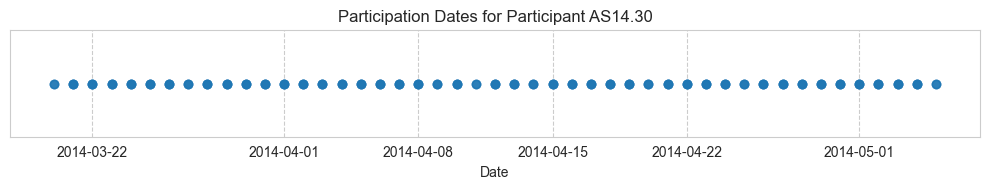

ID: AS14.31, Start: 2014-04-02, End: 2014-05-15, Timeframe: 43 days, 0:00:00 
 Missing Dates: 1
Missing mood measurement dates for participant AS14.31: [datetime.date(2014, 5, 6)]


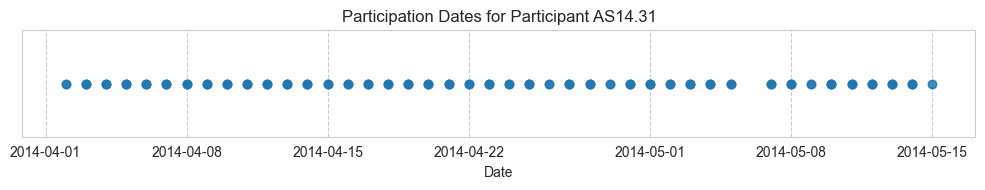

ID: AS14.32, Start: 2014-04-01, End: 2014-05-12, Timeframe: 41 days, 0:00:00 
 Missing Dates: 5
Missing mood measurement dates for participant AS14.32: [datetime.date(2014, 4, 19), datetime.date(2014, 4, 20), datetime.date(2014, 4, 22), datetime.date(2014, 4, 26), datetime.date(2014, 5, 6)]


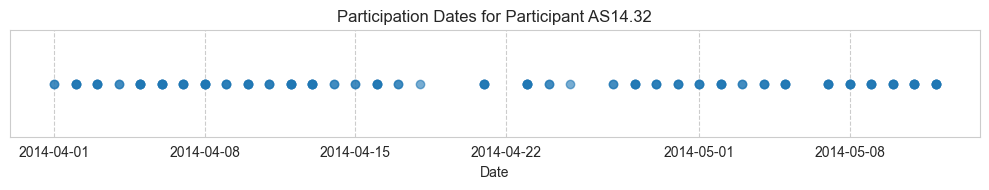

ID: AS14.33, Start: 2014-04-16, End: 2014-05-31, Timeframe: 45 days, 0:00:00 
 Missing Dates: 3
Missing mood measurement dates for participant AS14.33: [datetime.date(2014, 5, 2), datetime.date(2014, 5, 3), datetime.date(2014, 5, 6)]


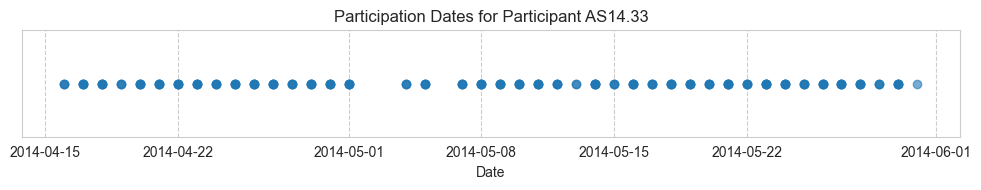

In [322]:
"""
Calculate end and start date of data collection for each participant. Missing mood dates are printed for each participant.
Conclusion: The amount of times in which mood is measured for the participants varies between 128 and 299 days. The timeframe in days in which mood was measured for each participant varies between 30 days and 67 days. 
"""
start_dates = []
end_dates = []

mood_measurements = df[df['variable'] == 'mood']

for participant in participants:
    id_df = mood_measurements.loc[(mood_measurements['id'] == participant)]

    start_date = id_df['date'].min()
    start_dates.append(start_date)
    end_date = id_df['date'].max()
    end_dates.append(end_date)

    # Convert mood measurement dates to datetime and get unique values
    mood_dates = pd.to_datetime(id_df['date']).dt.date.unique()
    
    # print(f'id: {participant}, start: {start_date}, end: {end_date}, days: {end_date - start_date}, mood count = {len(id_df)}')
    # 
       # Generate a Series of all dates between start and end
    all_dates = pd.date_range(start=start_date, end=end_date).date

 # Check for missing dates by comparing sets
    missing_dates = set(all_dates) - set(mood_dates)
    
    print(f'ID: {participant}, Start: {start_date}, End: {end_date}, Timeframe: {end_date - start_date} \n Missing Dates: {len(missing_dates)}')
    if len(missing_dates) > 0:
        print(f"Missing mood measurement dates for participant {participant}: {sorted(missing_dates)}")
    else:
        print(f"All dates between start and end have at least one mood measurement for participant {participant}.")
    print('')

# Plotting
    plt.figure(figsize=(10, 2))  # Adjust size as needed
    plt.scatter(id_df['date'], [1]*len(id_df), alpha=0.6)  # Plot a dot at y=1 for each date
    
    # Formatting the plot
    plt.title(f'Participation Dates for Participant {participant}')
    plt.yticks([])  # Hide y-axis ticks as they don't convey meaningful information in this case
    plt.xlabel('Date')
    
    # Option to set x-axis limits to cover the entire period of study if desired
    # plt.xlim(pd.to_datetime('start_date'), pd.to_datetime('end_date'))
    
    plt.grid(True, which='major', linestyle='--', axis='x')
    plt.tight_layout()  # Adjust layout to make room for the plot elements
    
    plt.show()

In [323]:
"""
Delete the mood measurements outside our prediction time frame (for example between 08:00 and 23:00)
"""

'\nDelete the mood measurements outside our prediction time frame (for example between 08:00 and 23:00)\n'

In [324]:
"""
Here I want to give each first day 
"""
# for participant in participants:
#     print('participant')
#     mood_measurements = df[df['variable'] == 'mood']
#     id_df = mood_measurements.loc[(df['id'] == participant)]
#     for date in id_df['date'].unique():
#          = df_time.groupby(['hour', 'variable'])['value'].sum().reset_index()


'\nHere I want to give each first day \n'